In [ ]:
!pip install --upgrade tqdm

In [ ]:
"""Random Forest Regression for Rossmann Sales Prediction

This code is adapted from the XGBoost version to use RandomForestRegressor.
"""

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import joblib  # for saving/loading models

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
def load_data(train_path='train.csv', store_path='store.csv'):
    """
    Loads the Rossmann train and store datasets.
    Args:
      train_path (str): Path to train.csv file.
      store_path (str): Path to store.csv file.
    Returns:
      train (DataFrame): Training dataset.
      store (DataFrame): Store-specific data.
    """
    train = pd.read_csv(train_path, parse_dates=['Date'])
    store = pd.read_csv(store_path)
    return train, store

In [ ]:
def merge_data(train, store):
    """
    Merge the train dataset with the store dataset on the 'Store' column.
    Args:
      train (DataFrame): Training dataset.
      store (DataFrame): Store-specific dataset.
    Returns:
      df (DataFrame): Merged dataset.
    """
    df = pd.merge(train, store, on='Store', how='left')
    return df

In [ ]:
def preprocess_data(df):
    """
    Preprocess the merged dataframe:
      - Remove rows where Sales are 0 (closed stores or irrelevant days).
      - Fill missing values.
    Args:
      df (DataFrame): Merged dataset.
    Returns:
      df (DataFrame): Cleaned dataset.
    """
    # Remove records with zero sales
    if 'Sales' in df.columns:
        df = df[df['Sales'] > 0].copy()

    # Fill missing CompetitionDistance with a large number (max value)
    df['CompetitionDistance'].fillna(df['CompetitionDistance'].max(), inplace=True)

    # Fill missing competition open columns with corresponding year/month from Date
    df['CompetitionOpenSinceYear'].fillna(df['Date'].dt.year, inplace=True)
    df['CompetitionOpenSinceMonth'].fillna(df['Date'].dt.month, inplace=True)

    # Fill missing Promo2 related values with defaults
    df['Promo2SinceWeek'].fillna(0, inplace=True)
    df['Promo2SinceYear'].fillna(0, inplace=True)
    df['PromoInterval'].fillna("None", inplace=True)

    return df

In [ ]:
def feature_engineering(df):
    """
    Create new features:
      - Date-related features.
      - Competition open since.
      - Promo2 duration.
      - [New] RFM features (Recency, Frequency, Monetary) for training data.
      - One-hot encoding for categorical features.
    Args:
      df (DataFrame): Preprocessed dataframe.
    Returns:
      df (DataFrame): DataFrame with engineered features.
    """
    # Date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

    # Competition open since (combine year and month)
    df['CompetitionOpenSince'] = df['CompetitionOpenSinceYear'].astype(int) * 100 + df['CompetitionOpenSinceMonth'].astype(int)

    # Promo2 duration
    df['Promo2SinceYear'] = df['Promo2SinceYear'].astype(int)
    df['Promo2SinceWeek'] = df['Promo2SinceWeek'].astype(int)
    df['Promo2Active'] = df['Promo2'].apply(lambda x: 1 if x == 1 else 0)
    df['Promo2Since'] = df.apply(lambda row: (row['Year'] - row['Promo2SinceYear']) * 12 + (row['Month'] - (row['Promo2SinceWeek'] // 4 + 1))
                                 if row['Promo2Active'] == 1 and row['Promo2SinceYear'] > 0 else 0, axis=1)

    if 'Sales' in df.columns:
        # Log-transform target variable "Sales"
        df['LogSales'] = np.log1p(df['Sales'])

        # NEW: RFM Feature Engineering
        ref_date = df['Date'].max()
        rfm = df.groupby('Store').agg(
            Recency=('Date', lambda x: (ref_date - x.max()).days),
            Frequency=('Sales', 'count'),
            Monetary=('Sales', 'sum')
        ).reset_index()
        rfm['Recency'] = np.log1p(rfm['Recency'])
        rfm['Frequency'] = np.log1p(rfm['Frequency'])
        rfm['Monetary'] = np.log1p(rfm['Monetary'])
        # Save RFM features globally for test merge
        global rfm_features
        rfm_features = rfm.copy()
        df = pd.merge(df, rfm_features, on='Store', how='left')
    else:
        # For test data, merge pre-computed RFM features if available
        try:
            df = pd.merge(df, rfm_features, on='Store', how='left')
        except NameError:
            pass

    # One-hot encode categorical features
    df = pd.get_dummies(df, columns=['StateHoliday', 'StoreType', 'Assortment'], drop_first=True)

    return df

In [ ]:
def eda(df):
    """
    Perform Exploratory Data Analysis:
      - Plot distribution of Sales.
      - Time-series plot for a sample store.
      - Correlation heatmap.
    Args:
      df (DataFrame): DataFrame after feature engineering.
    """
    plt.figure(figsize=(10, 5))
    sns.histplot(df['Sales'], bins=50, kde=True)
    plt.title("Distribution of Sales")
    plt.xlabel("Sales")
    plt.ylabel("Frequency")
    plt.show()

    # Time-series plot for store 1
    store1 = df[df['Store'] == 1].sort_values(by='Date')
    plt.figure(figsize=(12, 5))
    plt.plot(store1['Date'], store1['Sales'], marker='o', linestyle='-', markersize=3)
    plt.title("Store 1 Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title("Correlation Heatmap")
    plt.show()

In [ ]:
def train_model(X_train, y_train):
    """
    Train a Random Forest Regressor by manually iterating over a few random hyperparameter combinations,
    with 2-fold cross-validation. A progress bar (tqdm) displays progress.

    This approach avoids potential issues with tqdm integration and is designed to finish in under 30 minutes
    on a single-core CPU.

    Args:
      X_train (DataFrame): Training features.
      y_train (Series): Target variable.

    Returns:
      best_model: The trained Random Forest model with the best parameters found.
    """
    import numpy as np
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import KFold
    from tqdm import tqdm
    import random

    # Define hyperparameter options.
    n_estimators_options = [50, 80]    # Fewer trees to speed up training.
    max_depth_options = [10, None]           # Limit tree depth.
    min_samples_split_options = [2]          # Only one option to keep search space small.

    # Generate all possible combinations.
    param_combinations = []
    for n in n_estimators_options:
        for md in max_depth_options:
            for mss in min_samples_split_options:
                param_combinations.append({'n_estimators': n, 'max_depth': md, 'min_samples_split': mss})

    # Randomly select a few combinations to try.
    n_iter = 4  # Number of random combinations to try.
    chosen_params = random.sample(param_combinations, n_iter)

    cv = 2  # Use 2-fold cross-validation.
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    total_iters = n_iter * cv  # Total iterations for progress bar.
    best_score = float('inf')
    best_params = None
    best_model = None

    # Create a tqdm progress bar.
    pbar = tqdm(total=total_iters, desc="Randomized Search Progress", unit="fold")

    # Loop over each set of randomly selected hyperparameters.
    for params in chosen_params:
        # Create a new model with the current parameters.
        model = RandomForestRegressor(random_state=42, n_jobs=1, **params)
        cv_scores = []
        # 2-fold cross-validation.
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(X_tr, y_tr)
            preds = model.predict(X_val)
            rmse = np.sqrt(np.mean((y_val - preds) ** 2))
            cv_scores.append(rmse)
            pbar.update(1)
        avg_score = np.mean(cv_scores)
        # Save model if it's the best so far.
        if avg_score < best_score:
            best_score = avg_score
            best_params = params
            best_model = model
    pbar.close()

    print("Best parameters found:", best_params)
    print("Best RMSE:", best_score)

    return best_model


In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using RMSE, MAE, and MAPE.
    Plot actual vs. predicted log sales.
    Args:
      model: Trained model.
      X_test (DataFrame): Test features.
      y_test (Series): Test target values.
    """
    predictions = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

    print("Evaluation Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot actual vs. predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
    plt.xlabel("Actual Log Sales")
    plt.ylabel("Predicted Log Sales")
    plt.title("Actual vs. Predicted Log Sales")
    plt.show()

In [ ]:
def main():
    """
    1. Load and merge data.
    2. Preprocess and feature engineer.
    3. Perform EDA.
    4. Prepare data for modeling.
    5. Train Random Forest model with hyperparameter tuning.
    6. Evaluate model performance.
    """
    # 1. Load data
    train, store = load_data()
    print("Train and Store data loaded.")

    # 2. Merge data
    df = merge_data(train, store)
    print("Data merged. Shape:", df.shape)

    # 3. Preprocess data
    df = preprocess_data(df)
    print("Data preprocessed. Shape:", df.shape)

    # 4. Feature engineering
    df = feature_engineering(df)
    print("Feature engineering completed. New shape:", df.shape)

    # 5. Exploratory Data Analysis (EDA)
    print("Starting EDA...")
    # eda(df)

    # 6. Prepare data for modeling
    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']
    features = df.drop(columns=drop_cols, errors='ignore')
    features = features.select_dtypes(include=[np.number])

    X = features
    y = df['LogSales']  # Predicting log-transformed sales

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Data split into training and testing sets.")

    # 7. Train the Random Forest model
    print("Training the Random Forest model...")
    model = train_model(X_train, y_train)

    # 8. Evaluate the model
    print("Evaluating the model...")
    evaluate_model(model, X_test, y_test)

    # Save the trained model
    joblib.dump(model, 'rf_rossmann_model.pkl')
    print("Model saved to rf_rossmann_model.pkl")

    print("Pipeline completed.")

Train and Store data loaded.
Data merged. Shape: (1017209, 18)
Data preprocessed. Shape: (844338, 18)
Feature engineering completed. New shape: (844338, 36)
Starting EDA...
Data split into training and testing sets.
Training the Random Forest model...


Randomized Search Progress: 100%|██████████| 8/8 [25:44<00:00, 193.11s/fold]


Best parameters found: {'n_estimators': 80, 'max_depth': None, 'min_samples_split': 2}
Best RMSE: 0.11739871974163568
Evaluating the model...
Evaluation Metrics:
RMSE: 0.12
MAE: 0.08
MAPE: 0.96%


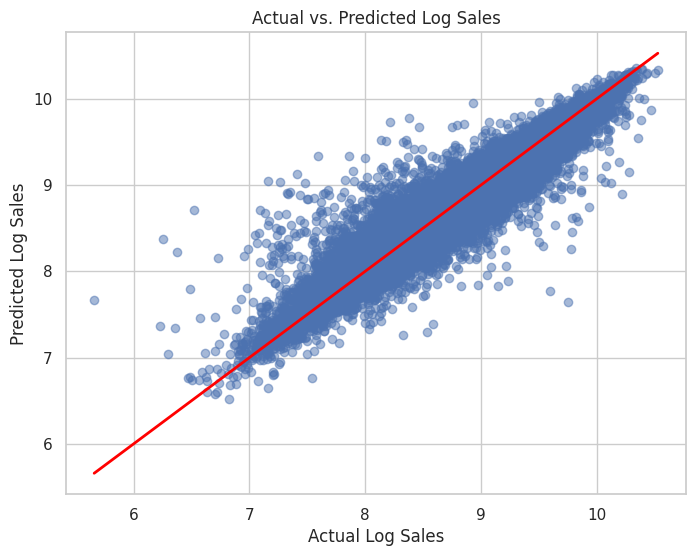

Model saved to rf_rossmann_model.pkl
Pipeline completed.


In [ ]:
main()

In [ ]:
def evaluate_test_data(model, merged_test_df):
    """
    Evaluate the external test dataframe using the trained model.
    Applies the same preprocessing and feature engineering as training.
    Args:
      model: Trained Random Forest model.
      merged_test_df (DataFrame): Merged test data (test.csv merged with store.csv).
    Returns:
      preds (ndarray): Model predictions.
    """
    test_clean = preprocess_data(merged_test_df)
    test_fe = feature_engineering(test_clean)

    drop_cols = ['Id', 'Sales', 'Date', 'LogSales', 'Customers']
    X_test = test_fe.drop(columns=[col for col in drop_cols if col in test_fe.columns], errors='ignore')
    X_test = X_test.select_dtypes(include=[np.number])

    preds = model.predict(X_test)
    return preds

In [ ]:
print("Loading and merging external test data...")
external_test_df = pd.read_csv('test.csv', parse_dates=['Date'])
store_df = pd.read_csv('store.csv')
external_merged = pd.merge(external_test_df, store_df, on='Store', how='left')

print("Evaluating external test data...")
rf_model = joblib.load('rf_rossmann_model.pkl')
pred = evaluate_test_data(rf_model, external_merged)

# Create submission.csv with the predicted Sales (inverse transform of log1p)
submission_df = pd.DataFrame({'Id': external_merged['Id'], 'Sales': np.expm1(pred)})
submission_df.to_csv('submission.csv', index=False)
print("submission.csv created.")

In [ ]:
def verify_submission_format(filepath):
    """
    Verifies the format of the submission CSV file.
    Args:
      filepath: The path to the submission CSV file.
    Returns:
      True if the file meets the format requirements, False otherwise.
    """
    try:
        submission_df = pd.read_csv(filepath)
        if len(submission_df) == 41088 and 'Id' in submission_df.columns and 'Sales' in submission_df.columns:
            print("Submission file format is correct.")
            return True
        else:
            print("Error: Incorrect number of rows or missing columns in submission file.")
            return False
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return False
    except pd.errors.EmptyDataError:
        print(f"Error: File '{filepath}' is empty.")
        return False
    except pd.errors.ParserError:
        print(f"Error: Unable to parse '{filepath}'. Check if it is a valid CSV.")
        return False

In [ ]:
is_valid = verify_submission_format('submission.csv')
print("Submission valid:", is_valid)

print("Loading train.csv and displaying columns with index numbers...")
train_df = pd.read_csv('train.csv')
for i, col in enumerate(train_df.columns):
    print(f"{i}: {col}")